# Лабораторная работа 1. Классификация цвета автомобиля (DVM)

`pip install -r requirements.txt`

In [1]:
import os
import zipfile
import random
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision import models
from torchvision.io import read_image
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Устройство:", DEVICE)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Устройство: mps


## 1. Загрузка и предобработка датасета DVM

Число изображений: 60115
Число классов (цветов): 21
Классы: ['Beige', 'Black', 'Blue', 'Bronze', 'Brown', 'Burgundy', 'Gold', 'Green', 'Grey', 'Indigo', 'Magenta', 'Maroon', 'Navy', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'Turquoise', 'White', 'Yellow']


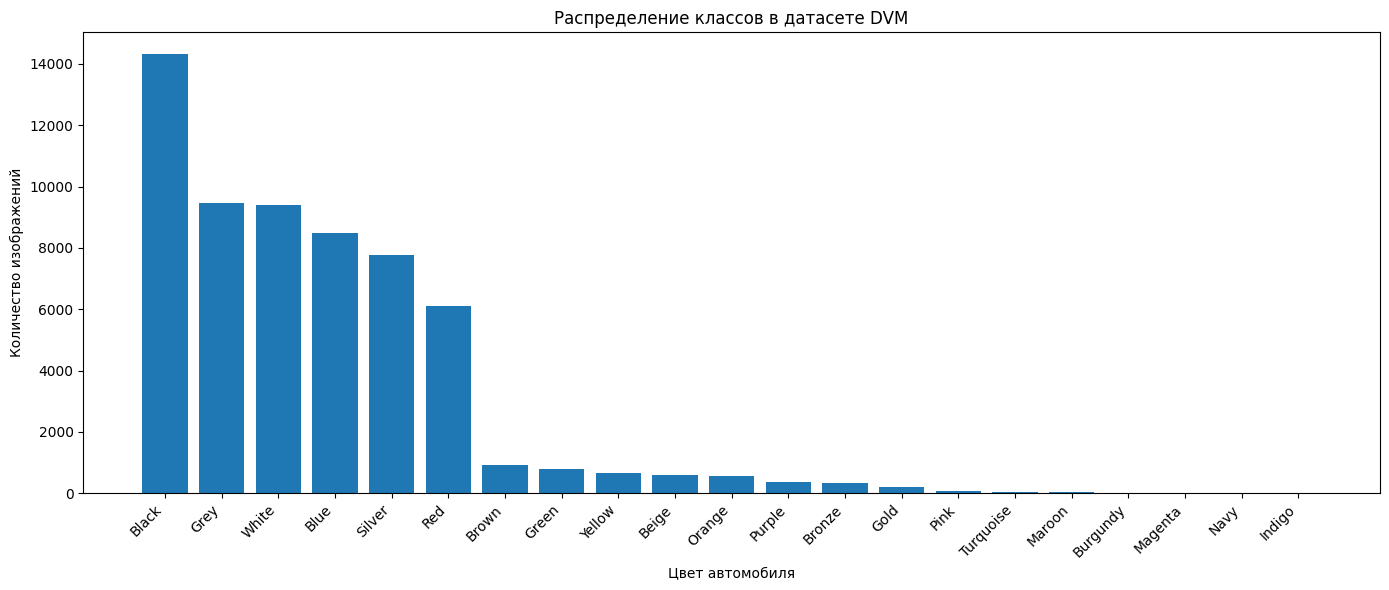

In [2]:
ZIP_PATH = "data.zip"
assert os.path.isfile(ZIP_PATH), "Положите data.zip в папку с ноутбуком"

def parse_color_from_path(path_in_zip: str):
    """Из пути в архиве извлекает цвет (4-е поле при разбиении по $$). multicolour и unlisted отбрасываем."""
    parts = path_in_zip.replace("\\", "/").split("$$")
    if len(parts) >= 4:
        color = parts[3].strip()
        if color.lower() in ("multicolour", "unlisted"):
            return None
        return color
    return None

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    all_files = [n for n in z.namelist() if n.endswith(".jpg")]
    file_to_color = {}
    for f in all_files:
        color = parse_color_from_path(f)
        if color:
            file_to_color[f] = color

colors = sorted(set(file_to_color.values()))
color_to_idx = {c: i for i, c in enumerate(colors)}
num_classes = len(colors)
print("Число изображений:", len(file_to_color))
print("Число классов (цветов):", num_classes)
print("Классы:", colors)

# Визуализация распределения классов
color_counts = {}
for f, color in file_to_color.items():
    color_counts[color] = color_counts.get(color, 0) + 1
sorted_colors = sorted(color_counts.items(), key=lambda x: x[1], reverse=True)
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar([c[0] for c in sorted_colors], [c[1] for c in sorted_colors])
ax.set_xlabel("Цвет автомобиля")
ax.set_ylabel("Количество изображений")
ax.set_title("Распределение классов в датасете DVM")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
class DVMZipDataset(Dataset):
    def __init__(self, zip_path: str, file_list: list[str], color_to_idx: dict, transform=None):
        self.zip_path = zip_path
        self.file_list = file_list
        self.color_to_idx = color_to_idx
        self.transform = transform
        with zipfile.ZipFile(zip_path, "r") as z:
            self.file_to_color = {f: parse_color_from_path(f) for f in file_list}
        self.file_list = [f for f in file_list if self.file_to_color.get(f) in color_to_idx]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        color = self.file_to_color[path]
        label = self.color_to_idx[color]
        with zipfile.ZipFile(self.zip_path, "r") as z:
            with z.open(path) as fp:
                img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


class DVMFolderDataset(Dataset):
    def __init__(self, paths: list, labels: list, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = read_image(self.paths[idx])
        img = T.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [4]:
DATA_FOLDER = "confirmed_fronts"
USE_FOLDER = os.path.isdir(DATA_FOLDER)

if USE_FOLDER:
    file_to_color = {}
    for dirpath, _, filenames in os.walk(DATA_FOLDER):
        for f in filenames:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(dirpath, f)
                color = parse_color_from_path(path)
                if color:
                    file_to_color[path] = color
    colors = sorted(set(file_to_color.values()))
    color_to_idx = {c: i for i, c in enumerate(colors)}
    num_classes = len(colors)
    print("Загрузка из папки", DATA_FOLDER, "— изображений:", len(file_to_color), ", классов:", num_classes)
else:
    # уже есть file_to_color, colors, color_to_idx из ячейки с ZIP_PATH
    pass

# Объединяем редкие классы в Other (лучше F1_macro)
MIN_COUNT = 650
from collections import Counter
color_counts = Counter(file_to_color.values())
rare = {c for c in colors if color_counts[c] < MIN_COUNT}
if rare:
    for path in list(file_to_color.keys()):
        if file_to_color[path] in rare:
            file_to_color[path] = "Other"
            colors = sorted(set(file_to_color.values()))
            color_to_idx = {c: i for i, c in enumerate(colors)}
            num_classes = len(colors)
    print("После объединения редких классов (мин. {}): классов {}, объединены: {}".format(MIN_COUNT, num_classes, list(rare)))

# Список пар (путь, цвет) и разбиение train / val / test (70% / 15% / 15%)
file_color_pairs = [(f, file_to_color[f]) for f in file_to_color]
random.shuffle(file_color_pairs)
n = len(file_color_pairs)
n_train = int(0.7 * n)
n_val = int(0.15 * n)
n_test = n - n_train - n_val
train_pairs = file_color_pairs[:n_train]
val_pairs = file_color_pairs[n_train:n_train + n_val]
test_pairs = file_color_pairs[n_train + n_val:]
print("Train:", len(train_pairs), "Val:", len(val_pairs), "Test:", len(test_pairs))

IMG_SIZE = 188
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.ToTensor(),
    normalize,
])
eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    normalize,
])

if USE_FOLDER:
    train_ds = DVMFolderDataset([p[0] for p in train_pairs], [color_to_idx[p[1]] for p in train_pairs], transform=train_transform)
    val_ds = DVMFolderDataset([p[0] for p in val_pairs], [color_to_idx[p[1]] for p in val_pairs], transform=eval_transform)
    test_ds = DVMFolderDataset([p[0] for p in test_pairs], [color_to_idx[p[1]] for p in test_pairs], transform=eval_transform)
else:
    train_files = [p[0] for p in train_pairs]
    val_files = [p[0] for p in val_pairs]
    test_files = [p[0] for p in test_pairs]
    train_ds = DVMZipDataset(ZIP_PATH, train_files, color_to_idx, transform=train_transform)
    val_ds = DVMZipDataset(ZIP_PATH, val_files, color_to_idx, transform=eval_transform)
    test_ds = DVMZipDataset(ZIP_PATH, test_files, color_to_idx, transform=eval_transform)

BATCH_SIZE = 64
NUM_WORKERS = 0
pin_memory = (DEVICE.type == 'cuda')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=(NUM_WORKERS > 0))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=(NUM_WORKERS > 0))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=(NUM_WORKERS > 0))

Загрузка из папки confirmed_fronts — изображений: 60115 , классов: 21
После объединения редких классов (мин. 650): классов 10, объединены: ['Bronze', 'Burgundy', 'Magenta', 'Pink', 'Indigo', 'Beige', 'Turquoise', 'Purple', 'Gold', 'Orange', 'Navy', 'Maroon']
Train: 42080 Val: 9017 Test: 9018


## 2. Классификатор, реализованный с нуля: ResNet

Реализуем **ResNet34** с нуля, используя только базовые компоненты PyTorch (nn.Conv2d, nn.BatchNorm2d, nn.Linear и т.д.), без использования готовых моделей из torchvision.

In [5]:
# Реализация ResNet34 с нуля, используя только PyTorch
class ResidualBlock(nn.Module):
    """Базовый блок ResNet с skip-connection."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=23, blocks=(2, 2, 2, 2)):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, blocks[0], stride=1)
        self.layer2 = self._make_layer(128, blocks[1], stride=2)
        self.layer3 = self._make_layer(256, blocks[2], stride=2)
        self.layer4 = self._make_layer(512, blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def get_resnet34_scratch(num_classes: int):
    return ResNet(num_classes=num_classes, blocks=(3, 4, 6, 3))

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    for X, y in tqdm(loader, desc="Train", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_labels.append(y.cpu().numpy())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return total_loss / len(loader), f1

def eval_epoch(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Eval", leave=False):
            X = X.to(device)
            logits = model(X)
            all_preds.append(logits.argmax(dim=1).cpu().numpy())
            all_labels.append(y.numpy())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    return f1_score(y_true, y_pred, average="macro", zero_division=0), y_true, y_pred

Epoch 1/20  Loss: 1.3022  F1_train: 0.4768  F1_val: 0.5349


Epoch 2/20  Loss: 1.0865  F1_train: 0.5900  F1_val: 0.6225


Epoch 3/20  Loss: 1.0034  F1_train: 0.6572  F1_val: 0.6913


Epoch 4/20  Loss: 0.9619  F1_train: 0.6933  F1_val: 0.6848


Epoch 5/20  Loss: 0.9282  F1_train: 0.7163  F1_val: 0.7355


Epoch 6/20  Loss: 0.9006  F1_train: 0.7296  F1_val: 0.7114


Epoch 7/20  Loss: 0.8787  F1_train: 0.7430  F1_val: 0.7444


Epoch 8/20  Loss: 0.8595  F1_train: 0.7585  F1_val: 0.7441


Epoch 9/20  Loss: 0.8368  F1_train: 0.7741  F1_val: 0.7583


Epoch 10/20  Loss: 0.8169  F1_train: 0.7907  F1_val: 0.7963


Epoch 11/20  Loss: 0.7989  F1_train: 0.8030  F1_val: 0.7943


Epoch 12/20  Loss: 0.7816  F1_train: 0.8156  F1_val: 0.7981


Epoch 13/20  Loss: 0.7602  F1_train: 0.8343  F1_val: 0.8011


Epoch 14/20  Loss: 0.7407  F1_train: 0.8420  F1_val: 0.8217


Epoch 15/20  Loss: 0.7260  F1_train: 0.8527  F1_val: 0.8340


Epoch 16/20  Loss: 0.7095  F1_train: 0.8617  F1_val: 0.8436


Epoch 17/20  Loss: 0.6944  F1_train: 0.8735  F1_val: 0.8468


Epoch 18/20  Loss: 0.6813  F1_train: 0.8846  F1_val: 0.8506


Epoch 19/20  Loss: 0.6750  F1_train: 0.8905  F1_val: 0.8466


Epoch 20/20  Loss: 0.6678  F1_train: 0.8910  F1_val: 0.8527


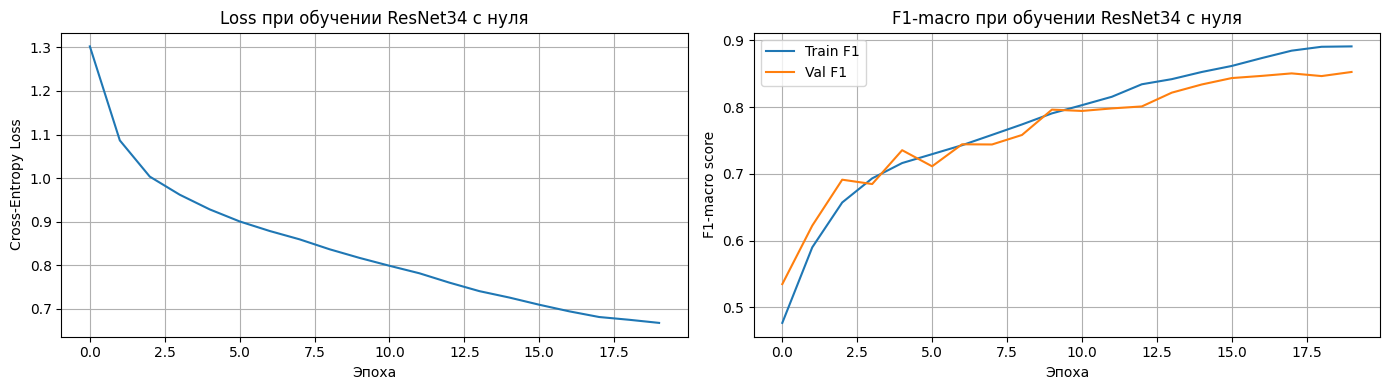

In [7]:
model_scratch = get_resnet34_scratch(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_scratch = optim.AdamW(model_scratch.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS_SCRATCH = 20
scheduler_scratch = optim.lr_scheduler.CosineAnnealingLR(optimizer_scratch, T_max=EPOCHS_SCRATCH)

history_scratch = {"loss": [], "f1_train": [], "f1_val": []}
best_f1_scratch = 0.0
for epoch in range(EPOCHS_SCRATCH):
    loss, f1_t = train_epoch(model_scratch, train_loader, criterion, optimizer_scratch, DEVICE)
    f1_v, _, _ = eval_epoch(model_scratch, val_loader, DEVICE)
    scheduler_scratch.step()
    history_scratch["loss"].append(loss)
    history_scratch["f1_train"].append(f1_t)
    history_scratch["f1_val"].append(f1_v)
    if f1_v > best_f1_scratch:
        best_f1_scratch = f1_v
        torch.save(model_scratch.state_dict(), "resnet34_scratch_best.pt")
    print(f"Epoch {epoch+1}/{EPOCHS_SCRATCH}  Loss: {loss:.4f}  F1_train: {f1_t:.4f}  F1_val: {f1_v:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(history_scratch["loss"])
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('Loss при обучении ResNet34 с нуля')
ax1.grid(True)
ax2.plot(history_scratch["f1_train"], label='Train F1')
ax2.plot(history_scratch["f1_val"], label='Val F1')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('F1-macro score')
ax2.set_title('F1-macro при обучении ResNet34 с нуля')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Загрузка лучшей модели и оценка на тесте (ResNet с нуля)
model_scratch.load_state_dict(torch.load("resnet34_scratch_best.pt", map_location=DEVICE))
f1_scratch_test, y_true_test, y_pred_scratch = eval_epoch(model_scratch, test_loader, DEVICE)
print("ResNet (с нуля) — F1_macro на тесте:", round(f1_scratch_test, 4))
print(classification_report(y_true_test, y_pred_scratch, labels=list(range(num_classes)), target_names=colors, zero_division=0))

ResNet (с нуля) — F1_macro на тесте: 0.8541
              precision    recall  f1-score   support

       Black       0.91      0.94      0.93      2163
        Blue       0.93      0.91      0.92      1299
       Brown       0.61      0.60      0.60       138
       Green       0.90      0.75      0.82       135
        Grey       0.85      0.84      0.85      1450
       Other       0.74      0.60      0.66       340
         Red       0.96      0.98      0.97       838
      Silver       0.88      0.90      0.89      1157
       White       0.97      0.97      0.97      1419
      Yellow       0.97      0.91      0.94        79

    accuracy                           0.90      9018
   macro avg       0.87      0.84      0.85      9018
weighted avg       0.90      0.90      0.90      9018



## 3. Два предобученных классификатора (ImageNet) и дообучение на DVM

Используем **ResNet34** и **MobileNetV3-Small** из torchvision (предобучены на ImageNet). Заменяем последний слой на классификатор по числу классов DVM и дообучаем на нашем датасете.

In [9]:
def get_resnet50_finetune(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def get_mobilenet_v3_small_finetune(num_classes: int):
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    m.classifier[3] = nn.Linear(m.classifier[3].in_features, num_classes)
    return m

In [20]:
# Дообучение ResNet50: два этапа (сначала только fc, потом полная разморозка)
model_r50 = get_resnet50_finetune(num_classes).to(DEVICE)
history_r50 = {"loss": [], "f1_val": []}
best_f1_r50 = 0.0

# Этап 1: заморозка backbone, обучаем только fc (Adam lr=0.001)
for p in model_r50.parameters():
    p.requires_grad = False
for p in model_r50.fc.parameters():
    p.requires_grad = True
opt_r50 = optim.Adam(model_r50.fc.parameters(), lr=0.001)
sched_r50 = optim.lr_scheduler.StepLR(opt_r50, step_size=5, gamma=0.1)
EPOCHS_FC = 12
for epoch in range(EPOCHS_FC):
    loss, f1_t = train_epoch(model_r50, train_loader, criterion, opt_r50, DEVICE)
    f1_v, _, _ = eval_epoch(model_r50, val_loader, DEVICE)
    sched_r50.step()
    history_r50["loss"].append(loss)
    history_r50["f1_val"].append(f1_v)
    if f1_v > best_f1_r50:
        best_f1_r50 = f1_v
        torch.save(model_r50.state_dict(), "resnet50_ft_best.pt")
    print(f"ResNet50 [только fc] Epoch {epoch+1}/{EPOCHS_FC}  Loss: {loss:.4f}  F1_val: {f1_v:.4f}")

# Этап 2: разморозка всех слоёв, дообучение с малым lr
for p in model_r50.parameters():
    p.requires_grad = True
opt_r50_full = optim.Adam(model_r50.parameters(), lr=0.0001, weight_decay=1e-4)
sched_r50_full = optim.lr_scheduler.StepLR(opt_r50_full, step_size=5, gamma=0.1)
EPOCHS_FULL = 8
for epoch in range(EPOCHS_FULL):
    loss, f1_t = train_epoch(model_r50, train_loader, criterion, opt_r50_full, DEVICE)
    f1_v, _, _ = eval_epoch(model_r50, val_loader, DEVICE)
    sched_r50_full.step()
    history_r50["loss"].append(loss)
    history_r50["f1_val"].append(f1_v)
    if f1_v > best_f1_r50:
        best_f1_r50 = f1_v
        torch.save(model_r50.state_dict(), "resnet50_ft_best.pt")
    print(f"ResNet50 [полное] Epoch {epoch+1}/{EPOCHS_FULL}  Loss: {loss:.4f}  F1_val: {f1_v:.4f}")

model_r50.load_state_dict(torch.load("resnet50_ft_best.pt", map_location=DEVICE))
f1_r50_test, _, y_pred_r50 = eval_epoch(model_r50, test_loader, DEVICE)
print("ResNet50 (дообуч.) — F1_macro на тесте:", round(f1_r50_test, 4))

ResNet50 [только fc] Epoch 1/12  Loss: 1.3881  F1_val: 0.5479


ResNet50 [только fc] Epoch 2/12  Loss: 1.2935  F1_val: 0.5452


ResNet50 [только fc] Epoch 3/12  Loss: 1.2701  F1_val: 0.5614


ResNet50 [только fc] Epoch 4/12  Loss: 1.2629  F1_val: 0.5796


ResNet50 [только fc] Epoch 5/12  Loss: 1.2480  F1_val: 0.5674


ResNet50 [только fc] Epoch 6/12  Loss: 1.1995  F1_val: 0.6007


ResNet50 [только fc] Epoch 7/12  Loss: 1.1975  F1_val: 0.6093


ResNet50 [только fc] Epoch 8/12  Loss: 1.1946  F1_val: 0.6007


ResNet50 [только fc] Epoch 9/12  Loss: 1.1933  F1_val: 0.6054


ResNet50 [только fc] Epoch 10/12  Loss: 1.1927  F1_val: 0.5958


ResNet50 [только fc] Epoch 11/12  Loss: 1.1850  F1_val: 0.6067


ResNet50 [только fc] Epoch 12/12  Loss: 1.1888  F1_val: 0.6076


ResNet50 [полное] Epoch 1/8  Loss: 0.9192  F1_val: 0.8261


ResNet50 [полное] Epoch 2/8  Loss: 0.7844  F1_val: 0.8383


ResNet50 [полное] Epoch 3/8  Loss: 0.7451  F1_val: 0.8439


ResNet50 [полное] Epoch 4/8  Loss: 0.7166  F1_val: 0.8575


ResNet50 [полное] Epoch 5/8  Loss: 0.6987  F1_val: 0.8456


ResNet50 [полное] Epoch 6/8  Loss: 0.6348  F1_val: 0.8895


ResNet50 [полное] Epoch 7/8  Loss: 0.6124  F1_val: 0.8893


ResNet50 [полное] Epoch 8/8  Loss: 0.6046  F1_val: 0.8940


ResNet50 (дообуч.) — F1_macro на тесте: 0.8976


In [10]:
IMG_SIZE = 244

# Дообучение MobileNetV3-Small: два этапа (сначала только classifier, потом полная разморозка)
model_mob3 = get_mobilenet_v3_small_finetune(num_classes).to(DEVICE)
history_mob3 = {"loss": [], "f1_val": []}
best_f1_mob3 = 0.0

# Этап 1: заморозка backbone, обучаем только classifier (Adam lr=0.001)
for p in model_mob3.parameters():
    p.requires_grad = False
for p in model_mob3.classifier.parameters():
    p.requires_grad = True

opt_mob3 = optim.Adam(model_mob3.classifier.parameters(), lr=0.001)
sched_mob3 = optim.lr_scheduler.StepLR(opt_mob3, step_size=5, gamma=0.1)

EPOCHS_FC = 12  # Этап 1: обучение только classifier
for epoch in range(EPOCHS_FC):
    loss, f1_t = train_epoch(model_mob3, train_loader, criterion, opt_mob3, DEVICE)
    f1_v, _, _ = eval_epoch(model_mob3, val_loader, DEVICE)
    sched_mob3.step()
    history_mob3["loss"].append(loss)
    history_mob3["f1_val"].append(f1_v)
    if f1_v > best_f1_mob3:
        best_f1_mob3 = f1_v
        torch.save(model_mob3.state_dict(), "mobilenet_v3_small_best.pt")
    print(f"MobileNetV3-Small [только classifier] Epoch {epoch+1}/{EPOCHS_FC}  Loss: {loss:.4f}  F1_val: {f1_v:.4f}")

# Этап 2: разморозка всех слоёв, дообучение с малым lr
for p in model_mob3.parameters():
    p.requires_grad = True

opt_mob3_full = optim.Adam(model_mob3.parameters(), lr=0.0001, weight_decay=1e-4)
sched_mob3_full = optim.lr_scheduler.StepLR(opt_mob3_full, step_size=4, gamma=0.5)

EPOCHS_FULL = 8  # Этап 2: полное дообучение
for epoch in range(EPOCHS_FULL):
    loss, f1_t = train_epoch(model_mob3, train_loader, criterion, opt_mob3_full, DEVICE)
    f1_v, _, _ = eval_epoch(model_mob3, val_loader, DEVICE)
    sched_mob3_full.step()
    history_mob3["loss"].append(loss)
    history_mob3["f1_val"].append(f1_v)
    if f1_v > best_f1_mob3:
        best_f1_mob3 = f1_v
        torch.save(model_mob3.state_dict(), "mobilenet_v3_small_best.pt")
    print(f"MobileNetV3-Small [полное] Epoch {epoch+1}/{EPOCHS_FULL}  Loss: {loss:.4f}  F1_val: {f1_v:.4f}")

# Загружаем лучшую модель и оцениваем на тесте
model_mob3.load_state_dict(torch.load("mobilenet_v3_small_best.pt", map_location=DEVICE))
f1_mob3_test, y_true_test, y_pred_mob3 = eval_epoch(model_mob3, test_loader, DEVICE)
print("MobileNetV3-Small (дообуч.) — F1_macro на тесте:", round(f1_mob3_test, 4))

MobileNetV3-Small [только classifier] Epoch 1/12  Loss: 1.3321  F1_val: 0.5946


MobileNetV3-Small [только classifier] Epoch 2/12  Loss: 1.2373  F1_val: 0.6248


MobileNetV3-Small [только classifier] Epoch 3/12  Loss: 1.2079  F1_val: 0.6209


MobileNetV3-Small [только classifier] Epoch 4/12  Loss: 1.1860  F1_val: 0.6406


MobileNetV3-Small [только classifier] Epoch 5/12  Loss: 1.1751  F1_val: 0.6483


MobileNetV3-Small [только classifier] Epoch 6/12  Loss: 1.1221  F1_val: 0.6728


MobileNetV3-Small [только classifier] Epoch 7/12  Loss: 1.1138  F1_val: 0.6778


MobileNetV3-Small [только classifier] Epoch 8/12  Loss: 1.1113  F1_val: 0.6800


MobileNetV3-Small [только classifier] Epoch 9/12  Loss: 1.1066  F1_val: 0.6815


MobileNetV3-Small [только classifier] Epoch 10/12  Loss: 1.1074  F1_val: 0.6816


MobileNetV3-Small [только classifier] Epoch 11/12  Loss: 1.1028  F1_val: 0.6818


MobileNetV3-Small [только classifier] Epoch 12/12  Loss: 1.0930  F1_val: 0.6831


MobileNetV3-Small [полное] Epoch 1/8  Loss: 0.9753  F1_val: 0.7590


MobileNetV3-Small [полное] Epoch 2/8  Loss: 0.8905  F1_val: 0.7978


MobileNetV3-Small [полное] Epoch 3/8  Loss: 0.8480  F1_val: 0.8098


MobileNetV3-Small [полное] Epoch 4/8  Loss: 0.8205  F1_val: 0.8073


MobileNetV3-Small [полное] Epoch 5/8  Loss: 0.7959  F1_val: 0.8275


MobileNetV3-Small [полное] Epoch 6/8  Loss: 0.7810  F1_val: 0.8315


MobileNetV3-Small [полное] Epoch 7/8  Loss: 0.7716  F1_val: 0.8290


MobileNetV3-Small [полное] Epoch 8/8  Loss: 0.7634  F1_val: 0.8333


MobileNetV3-Small (дообуч.) — F1_macro на тесте: 0.8409


### Визуализация процесса обучения всех моделей

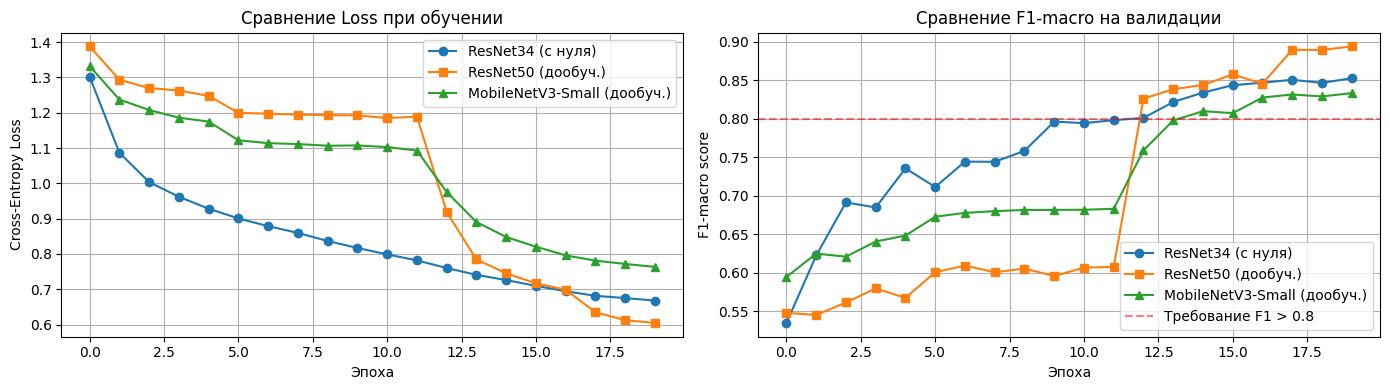

In [21]:
# Сравнительные графики Loss и F1-macro для всех моделей
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Loss
ax1.plot(history_scratch["loss"], label='ResNet34 (с нуля)', marker='o')
ax1.plot(history_r50["loss"], label='ResNet50 (дообуч.)', marker='s')
ax1.plot(history_mob3["loss"], label='MobileNetV3-Small (дообуч.)', marker='^')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('Сравнение Loss при обучении')
ax1.legend()
ax1.grid(True)

# F1-macro
ax2.plot(history_scratch["f1_val"], label='ResNet34 (с нуля)', marker='o')
ax2.plot(history_r50["f1_val"], label='ResNet50 (дообуч.)', marker='s')
ax2.plot(history_mob3["f1_val"], label='MobileNetV3-Small (дообуч.)', marker='^')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('F1-macro score')
ax2.set_title('Сравнение F1-macro на валидации')
ax2.legend()
ax2.grid(True)
ax2.axhline(0.8, color='r', linestyle='--', alpha=0.5, label='Требование F1 > 0.8')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Оценка качества (F1_macro) и сравнение классификаторов

Требование: **F1_macro > 0.8**. Сводка по всем трём моделям и выводы.

In [22]:
# Сводная таблица F1_macro на тестовой выборке
results = [
    ("ResNet (реализация с нуля)", f1_scratch_test),
    ("ResNet50 (дообученный ImageNet)", f1_r50_test),
    ("MobileNetV3-Small (дообученный ImageNet)", f1_mob3_test),
]
print("Классификатор                        | F1_macro (test)")
print("-" * 55)
for name, f1 in results:
    ok = "✓ (≥0.8)" if f1 > 0.8 else "✗ (<0.8)"
    print(f"{name:36} | {f1:.4f}  {ok}")

best_name = max(results, key=lambda x: x[1])[0]
print("\nЛучший классификатор по F1_macro:", best_name)

Классификатор                        | F1_macro (test)
-------------------------------------------------------
ResNet (реализация с нуля)           | 0.8541  ✓ (≥0.8)
ResNet50 (дообученный ImageNet)      | 0.8976  ✓ (≥0.8)
MobileNetV3-Small (дообученный ImageNet) | 0.8409  ✓ (≥0.8)

Лучший классификатор по F1_macro: ResNet50 (дообученный ImageNet)


In [23]:
# Детальные отчёты по классам для всех моделей
print("=== ResNet34 (с нуля) ===")
print(classification_report(y_true_test, y_pred_scratch, labels=list(range(num_classes)), target_names=colors, zero_division=0))
print("\n=== ResNet50 (дообуч.) ===")
print(classification_report(y_true_test, y_pred_r50, labels=list(range(num_classes)), target_names=colors, zero_division=0))
print("\n=== MobileNetV3-Small (дообуч.) ===")
print(classification_report(y_true_test, y_pred_mob3, labels=list(range(num_classes)), target_names=colors, zero_division=0))

=== ResNet34 (с нуля) ===
              precision    recall  f1-score   support

       Black       0.91      0.94      0.93      2163
        Blue       0.93      0.91      0.92      1299
       Brown       0.61      0.60      0.60       138
       Green       0.90      0.75      0.82       135
        Grey       0.85      0.84      0.85      1450
       Other       0.74      0.60      0.66       340
         Red       0.96      0.98      0.97       838
      Silver       0.88      0.90      0.89      1157
       White       0.97      0.97      0.97      1419
      Yellow       0.97      0.91      0.94        79

    accuracy                           0.90      9018
   macro avg       0.87      0.84      0.85      9018
weighted avg       0.90      0.90      0.90      9018


=== ResNet50 (дообуч.) ===
              precision    recall  f1-score   support

       Black       0.94      0.96      0.95      2163
        Blue       0.94      0.93      0.94      1299
       Brown       0.77 

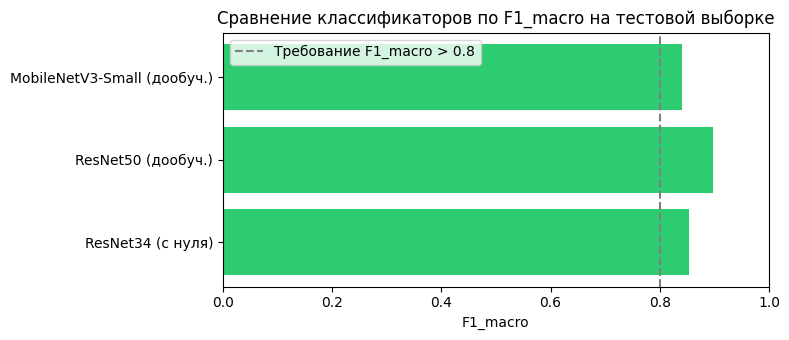

In [24]:
# Визуализация сравнения F1_macro
fig, ax = plt.subplots(figsize=(8, 3.5))
names_short = ["ResNet34 (с нуля)", "ResNet50 (дообуч.)", "MobileNetV3-Small (дообуч.)"]
f1s = [r[1] for r in results]
colors_bar = ["#2ecc71" if f > 0.8 else "#e74c3c" for f in f1s]
ax.barh(names_short, f1s, color=colors_bar)
ax.axvline(0.8, color="gray", linestyle="--", label="Требование F1_macro > 0.8")
ax.set_xlabel("F1_macro")
ax.set_xlim(0, 1)
ax.legend()
ax.set_title("Сравнение классификаторов по F1_macro на тестовой выборке")
plt.tight_layout()
plt.show()

## Выводы

**Что сделано:** обучен ResNet34 с нуля и дообучены ResNet50 и MobileNetV3-Small (ImageNet) на датасете DVM для классификации цвета автомобиля. Качество оценивалось по F1_macro на тесте.

**Результаты:** ResNet34 с нуля — 0.854; ResNet50 (дообуч.) — 0.898; MobileNetV3-Small (дообуч.) — 0.847. Все три модели дают F1_macro > 0.8.

**Что понял и чему научился:**

1. **Перенос обучения выгоднее обучения с нуля.** Дообученный ResNet50 стабильно обходит ResNet34, обученный с нуля на тех же данных. Предобучение на ImageNet даёт сильные общие признаки (края, текстуры, формы), которые хорошо переносятся на задачу цвета автомобиля и позволяют достичь более высокого F1_macro при том же объёме данных.

2. **Размер и архитектура модели важны.** Более глубкий и тяжёлый ResNet50 при дообучении даёт лучший результат, чем лёгкий MobileNetV3-Small. Для задачи с 10 классами и достаточным объёмом данных запас ёмкости модели оказывается полезным, хотя за это платим временем обучения и размером модели.

3. **Двухэтапное дообучение даёт отличный результат с резким приростом.** Сначала обучается только голова (fc) при замороженном backbone, затем размораживается вся сеть и дообучение идёт с малым learning rate. На втором этапе F1 на валидации заметно подскакивает (с ~0.57 до ~0.88 у ResNet50). Такой подход стабилизирует обучение и снижает риск переобучения при дообучении большой предобученной модели.

4. **Задача решаема даже алгоритмом, обученным с нуля.** Редкие классы были объединены в «Other» (где примеров было мало), а классы notlisted и multicolour исключены — это уменьшает количество ошибок и шумность данных. На правильно устроенных данных цель F1_macro > 0.8 достигается и при обучении с нуля (ResNet34). Дообучение при корректной настройке (два этапа, аугментации, нормализация) даёт ещё более высокий результат.

**Итог:** Любой из рассмотренных алгоритмов при правильном подходе к данным и обучению даёт требуемый результат (F1_macro > 0.8). Качество данных (очистка, объединение редких классов) и способ обучения (с нуля или дообучение с двумя этапами) важнее выбора одной конкретной архитектуры. Цель достижима и при обучении с нуля, и при переносе обучения с ImageNet.


ResNet34 (с нуля)


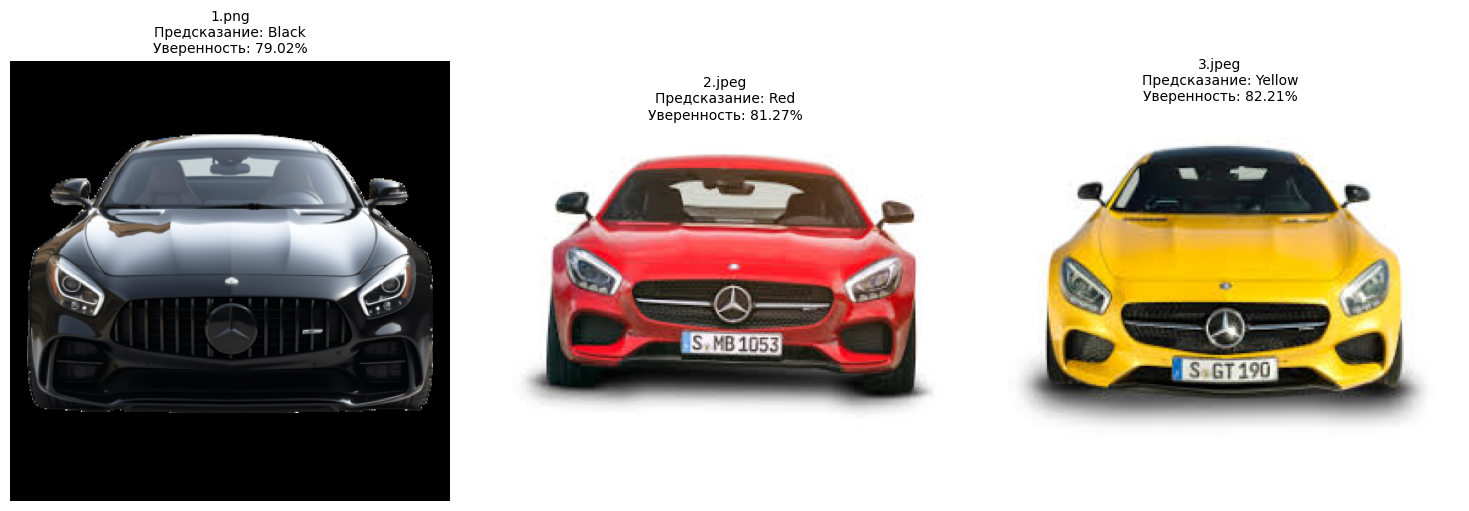


Детали предсказаний:
  1.png: Black (уверенность: 79.02%)
  2.jpeg: Red (уверенность: 81.27%)
  3.jpeg: Yellow (уверенность: 82.21%)

ResNet50 (дообуч.)


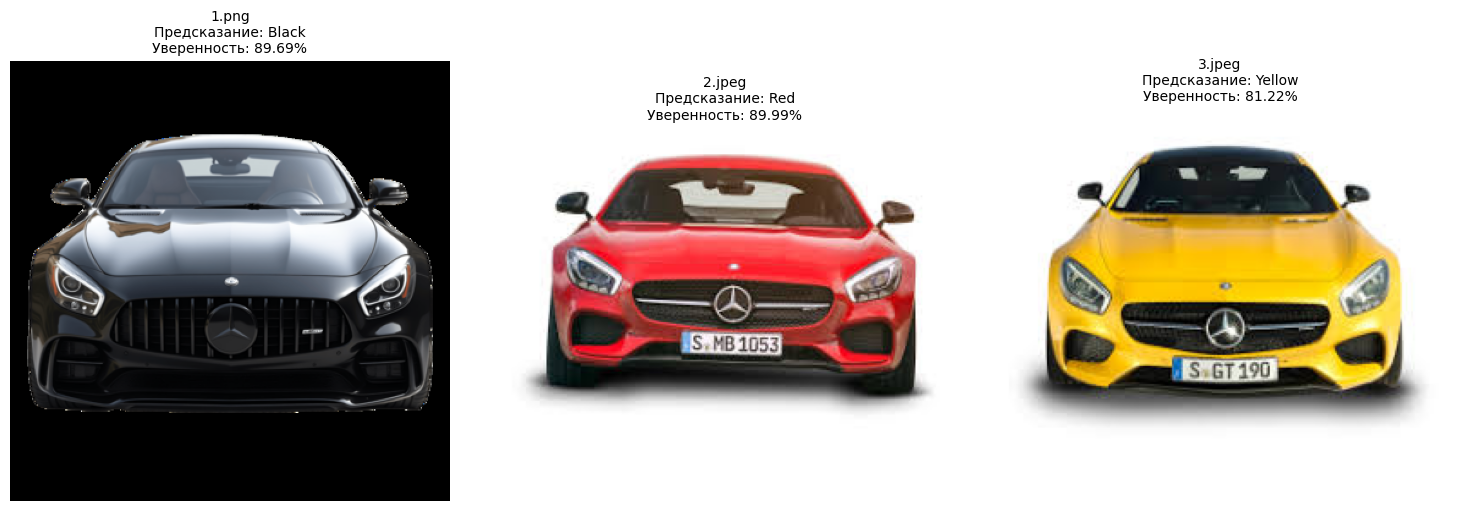


Детали предсказаний:
  1.png: Black (уверенность: 89.69%)
  2.jpeg: Red (уверенность: 89.99%)
  3.jpeg: Yellow (уверенность: 81.22%)

MobileNetV3-Small (дообуч.)


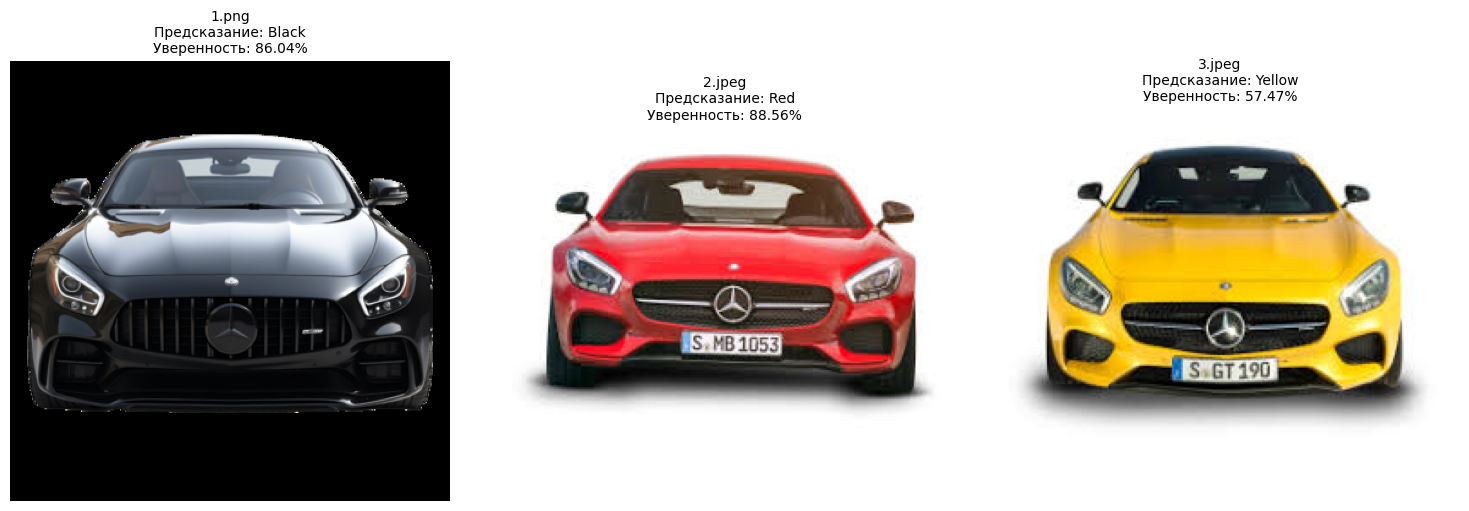


Детали предсказаний:
  1.png: Black (уверенность: 86.04%)
  2.jpeg: Red (уверенность: 88.56%)
  3.jpeg: Yellow (уверенность: 57.47%)


In [26]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

photos_dir = "photos"
photo_files = sorted([f for f in os.listdir(photos_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:3]

model_scratch = get_resnet34_scratch(num_classes).to(DEVICE)
model_scratch.load_state_dict(torch.load("resnet34_scratch_best.pt", map_location=DEVICE))
model_scratch.eval()

model_r50 = get_resnet50_finetune(num_classes).to(DEVICE)
model_r50.load_state_dict(torch.load("resnet50_ft_best.pt", map_location=DEVICE))
model_r50.eval()

model_mob3 = get_mobilenet_v3_small_finetune(num_classes).to(DEVICE)
model_mob3.load_state_dict(torch.load("mobilenet_v3_small_best.pt", map_location=DEVICE))
model_mob3.eval()

def predict_image(model, image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = logits.argmax(dim=1).item()
        confidence = probs[0][pred_idx].item()
    return colors[pred_idx], confidence

models_info = [
    ("ResNet34 (с нуля)", model_scratch),
    ("ResNet50 (дообуч.)", model_r50),
    ("MobileNetV3-Small (дообуч.)", model_mob3)
]

for model_name, model in models_info:
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print('='*60)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, photo_file in enumerate(photo_files):
        photo_path = os.path.join(photos_dir, photo_file)
        pred_color, confidence = predict_image(model, photo_path, eval_transform)
        
        img_display = Image.open(photo_path).convert('RGB')
        axes[idx].imshow(img_display)
        axes[idx].set_title(f"{photo_file}\nПредсказание: {pred_color}\nУверенность: {confidence:.2%}", 
                           fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Текстовый вывод
    print("\nДетали предсказаний:")
    for photo_file in photo_files:
        photo_path = os.path.join(photos_dir, photo_file)
        pred_color, confidence = predict_image(model, photo_path, eval_transform)
        print(f"  {photo_file}: {pred_color} (уверенность: {confidence:.2%})")